<a href="https://colab.research.google.com/github/LeonardoD99/GAS-ROI-FORECASTING/blob/main/gasScript.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Librairies

In [3]:
!pip install pingouin;

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7029 sha256=36e56f1593e6293186b190e6ae8b2914a01eb0921a8a8733d863d587b682fc4b
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils


In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import pingouin as pg
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from math import ceil
from prophet import Prophet

sns.set_theme()
pd.set_option('display.width', 1000)
# Define the tickers you want to get data for
tickers = ['CL=F', '^STOXX50E', '^TNX', '^GSPC']

# Define the start and end dates for the data
start_date = '2017-01-01'
end_date = '2021-06-01'

threshold = 'std' # 'std or 'q'

returns = {
    'features': {
      '1d_return' : 1,
      '7d_return' : 7,
      '30d_return' : 30,
      '90d_return' : 90,
    },
    'target' : {
      '30d_return' : 30,
      '90d_return' : 90,
      '180d_return' : 180,
    }
}

feature_return_names = list(returns['features'].keys())
target_return_names = list(returns['target'].keys())


In [5]:
target_return_names

['30d_return', '90d_return', '180d_return']

# Data acquisition

In [6]:
# Use yfinance to get the adjusted price for every tickers
data = yf.download(tickers, start=start_date, end=end_date).loc[:, 'Adj Close'].dropna()

file_path = 'https://raw.githubusercontent.com/LeonardoD99/GAS-ROI-FORECASTING/main/NGAS_TS%20-%20Historical%20Data.csv'
dataNGAS = pd.read_csv(file_path, parse_dates=['Date']).set_index('Date')
dataNGAS.rename(columns={'Price': 'NGAS.L'}, inplace=True)

[*********************100%***********************]  4 of 4 completed


In [7]:
data = data.merge(dataNGAS, left_index=True, right_index=True, how='left')

We selected a mix of macro, equities and fixed income variables. Eurostoxx and SP500 are the two main equity indices for Europe and US. TNX instead is the reference yield of the US 10 years government bond. The fixed income market is important for commodities pricing as discounting inflation expectations and market risk sentiment. The time series are available in the price domain, so we had to transform into returns at various frequencies. Given the nature of the asset class, we assumed a fixed duration for the 10 year government bond and used a first order linear approximation to estimate returns. For each time series we also calculated a momentum signal through trend filtering. We used for this a simple common used method, which is the difference of two exponentially weighted moving averages with different half lives. This is a simple proxy of the time series gradient and the method is called "moving average crossover".




In the above code:

1.   CL=F is the ticker symbol for crude oil futures
2.   ^STOXX50E is the ticker symbol for the Euro
3.   Stoxx 50 index
4.   ^TNX is the ticker symbol for the 10-year US Treasury yield
5. ^GSPC is the ticker symbol for the S&P 500 index


## Filling missing data

In [8]:
# here we check for data missing
dates_check = data.reset_index()['Date']

In [9]:
dates_check

0      2017-01-03
1      2017-01-04
2      2017-01-05
3      2017-01-06
4      2017-01-09
          ...    
1071   2021-05-21
1072   2021-05-25
1073   2021-05-26
1074   2021-05-27
1075   2021-05-28
Name: Date, Length: 1076, dtype: datetime64[ns]

In [10]:
dates_check['check'] =  dates_check.diff()
dates_check['check'].max()

Timedelta('6 days 00:00:00')

##  Features calculation
EMAS, MOMENTUM AND RETURNS




In [11]:
# Calculate the EMAs with half-life of 5, 10, and 30 days
for ticker in tickers:
    data[ticker + '_ema_5'] = data[ticker].ewm(halflife=5).mean()
    data[ticker + '_ema_10'] = data[ticker].ewm(halflife=10).mean()
    data[ticker + '_ema_30'] = data[ticker].ewm(halflife=30).mean()

# Calculate fast and slow momentum for each ticker
for ticker in tickers:
    data[ticker + '_fast_momentum'] = data[ticker + '_ema_5'] - data[ticker + '_ema_10']
    data[ticker + '_slow_momentum'] = data[ticker + '_ema_10'] - data[ticker + '_ema_30']

# Calculate rolling returns for each ticker
for ticker in tickers:
    if ticker == '^TNX':
        # Calculate returns for ^TNX with a different formula as this is a bond
        for key, val in returns['features'].items():
          data[ticker + '_' + key] = (data[ticker] - data[ticker].shift(val))/100 * -7
    else:
        #https://www.wikiwand.com/en/Rate_of_return#Logarithmic_or_continuously_compounded_return
        for key, val in returns['features'].items():
            data[ticker + '_' + key] = np.log(data[ticker] / data[ticker].shift(val)) # ln(V_t/V_t-val)

for key, val in returns['target'].items():
  data['target_' + key] = np.log(data['NGAS.L'].shift(-val) / data['NGAS.L']) # ln(V_t+val/V_t)

data.dropna(inplace = True)

Y = data.loc[:,['target_' + key for key in target_return_names]]
Y.rename(columns={'target_' + key: key for key in target_return_names},inplace=True)
data = data.drop(columns=['target_' + key for key in target_return_names]+['NGAS.L'])

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Data analysis

Text(0.5, 1.0, 'Return for : NGAS.L')

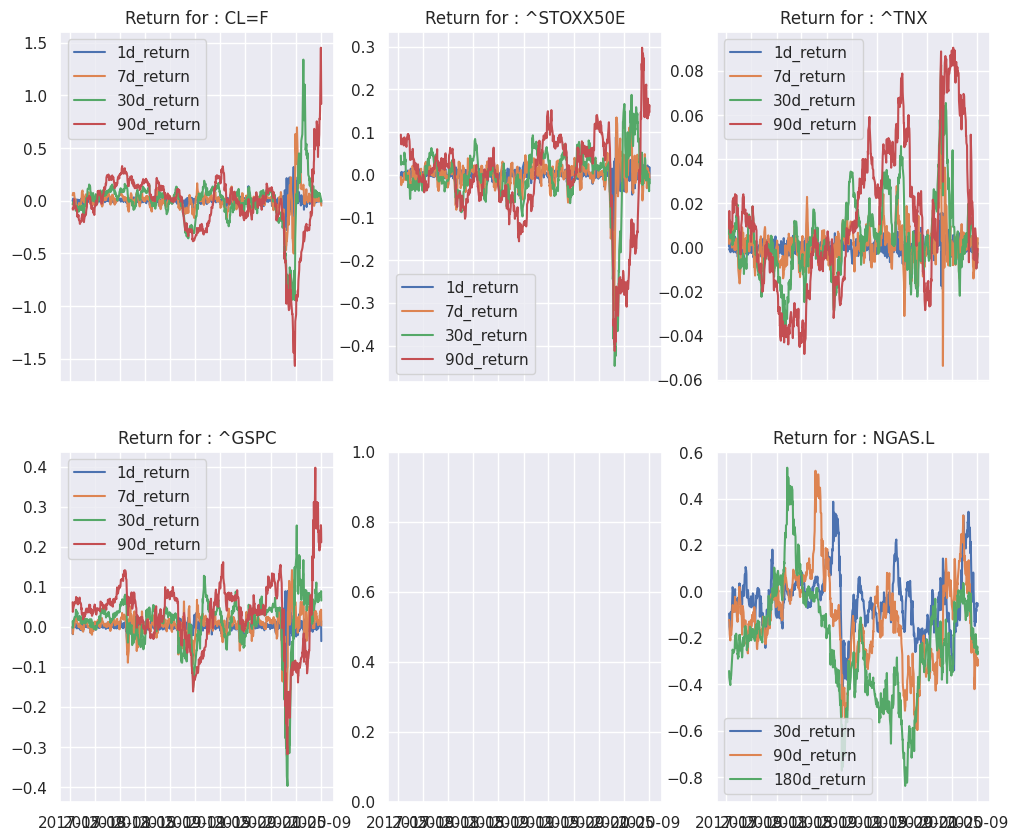

In [12]:
fig, axs = plt.subplots(ceil((len(tickers)+1)/3),3,figsize=(12*ceil((len(tickers)+1)//3), 10),sharex='all')


for i in range(len(tickers)):
  for x in feature_return_names:
    axs[i//3,i%3].plot(data[tickers[i] + '_' + x])
  axs[i//3,i%3].legend(feature_return_names)
  axs[i//3,i%3].set_title('Return for : {}'.format(tickers[i]))


index_plot = len(tickers)+1
for x in target_return_names:
  axs[index_plot//3,index_plot%3].plot(Y[x])
axs[index_plot//3,index_plot%3].legend(target_return_names)
axs[index_plot//3,index_plot%3].set_title('Return for : {}'.format('NGAS.L'))


## Time series seasonnal decomposition (spoiler: no trend )

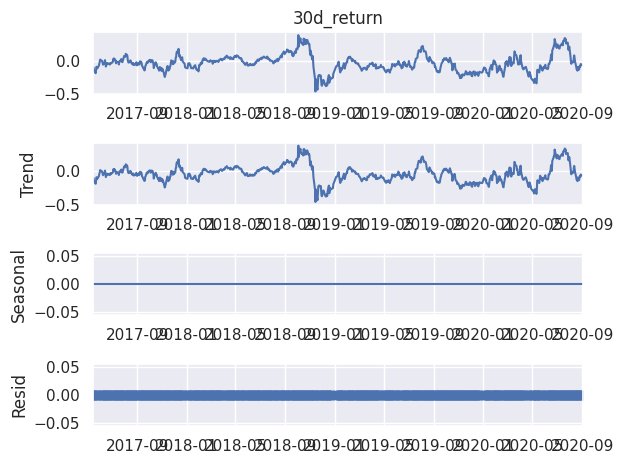

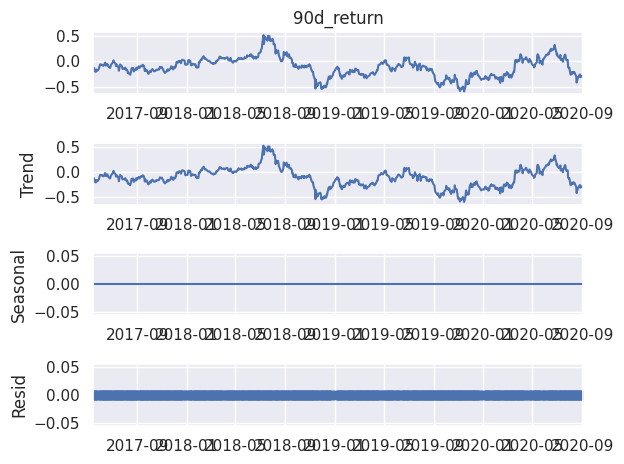

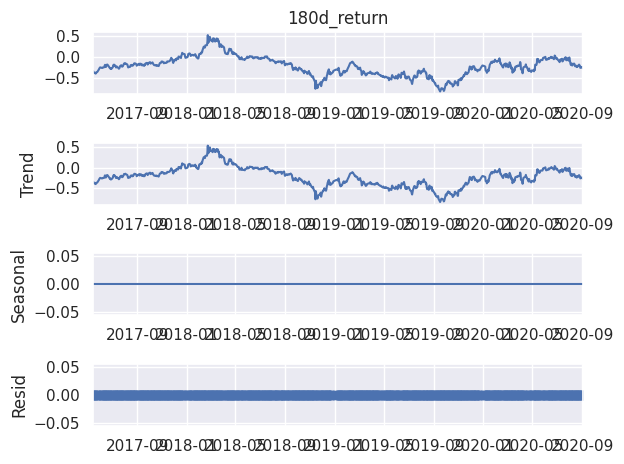

In [ ]:
import statsmodels.api as sm

for x in target_return_names:
  decomposition = sm.tsa.seasonal_decompose(Y[x], model = 'additive',period=1)
  decomposition.plot()

## Normality test

                                W          pval  normal
CL=F                     0.945202  1.522011e-16   False
^GSPC                    0.977966  1.451649e-09   False
^STOXX50E                0.928130  4.926870e-19   False
^TNX                     0.901961  4.062037e-22   False
CL=F_ema_5               0.934265  3.409265e-18   False
CL=F_ema_10              0.933408  2.582307e-18   False
CL=F_ema_30              0.929600  7.742850e-19   False
^STOXX50E_ema_5          0.933020  2.278982e-18   False
^STOXX50E_ema_10         0.942607  5.901535e-17   False
^STOXX50E_ema_30         0.951354  1.643620e-15   False
^TNX_ema_5               0.898492  1.769806e-22   False
^TNX_ema_10              0.897193  1.303743e-22   False
^TNX_ema_30              0.897628  1.443729e-22   False
^GSPC_ema_5              0.976081  4.168937e-10   False
^GSPC_ema_10             0.978288  1.807846e-09   False
^GSPC_ema_30             0.975241  2.438516e-10   False
CL=F_fast_momentum       0.872492  6.365459e-25 

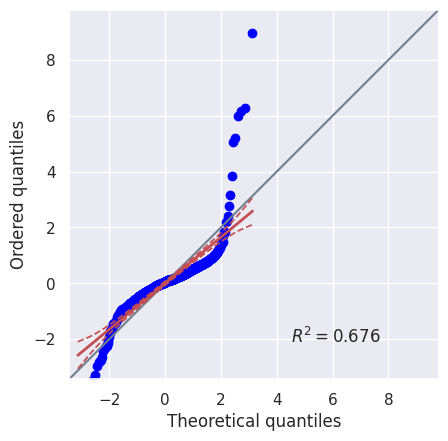

In [ ]:
result = pg.normality(data)
print(result)

ax = pg.qqplot(data['CL=F_1d_return'], dist='norm')

## Correlation analysis

### Correlation with inputs

In [ ]:
#print(pg.pairwise_corr(data, method='spearman'))

df = data.rcorr(decimals=2,upper='n',method='spearman').replace(['-',data.shape[0]],0).astype('float')
px.imshow(df,color_continuous_scale=["red","white","blue"])

### Correlation with target

In [ ]:
# TODO : corr targets
from scipy.stats import spearmanr

temp = pd.DataFrame(index=target_return_names)
for y in data.columns:
  L = []
  for x in target_return_names:
    L.append(spearmanr(Y[x],data[y]).statistic)
  temp[y] = L

px.imshow(temp,color_continuous_scale=["red", "white", "blue"])

# Data preprocessing

## Input / output data

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

input_columns = [col for col in data.columns if not('NGAS' in col)]
X = data[input_columns]

print('Number of initial features : {}'.format(len(input_columns)))

# input vector
Y_class =  pd.DataFrame() # target vector for class

if(threshold == 'q'):
  for x in target_return_names:
    Y_class[x] = np.where(Y[x] >= Y[x].quantile(0.75),'High Profit',
                          np.where(Y[x] >= Y[x].quantile(0.5),'Marginal Profit',
                              np.where(Y[x] >= Y[x].quantile(0.25),'Marginal Loss', 'High loss')
                          )
                )
elif(threshold == 'std'):
  for x in target_return_names:
    Y_class[x] = np.where(Y[x] >= Y[x].std(),'High Profit',
                          np.where(Y[x] >= 0,'Marginal Profit',
                              np.where(Y[x] >= -Y[x].std(),'Marginal Loss', 'High loss')
                          )
                )

print(pd.concat([Y_class[x].value_counts() for x in target_return_names],axis=1))

# Encode target classes as numerical labels
le = LabelEncoder()
Y_class_encoded = np.transpose(np.array([le.fit_transform(Y_class[x]) for x in Y_class.columns]))
target_names = le.classes_

# Split data into training and testing sets
X_train_class, X_test_class, Y_train_class, Y_test_class = train_test_split(X, Y_class_encoded, test_size=0.2, random_state=17)#, shuffle=False)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=17)#, shuffle=False)


Number of initial features : 40
                 30d_return  90d_return  180d_return
Marginal Loss           365         310          324
Marginal Profit         186         182           75
High loss               161         264          363
High Profit              81          37           31



## PCA


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

date_index_train = X_train.index
date_index_test = X_test.index


scaler = StandardScaler()
scaler.fit(X_train)
X = scaler.transform(X_train)

pca = PCA()
X_hat_train = pca.fit_transform(X_train)
X_hat_train = pd.DataFrame(index=date_index_train,data=X_hat_train)

X_hat_test = pca.transform(X_test)
X_hat_test = pd.DataFrame(index=date_index_test,data=X_hat_test)

X_hat_train_class = pca.fit_transform(X_train_class )
X_hat_train_class  = pd.DataFrame(index=date_index_train,data=X_hat_train_class )

X_hat_test_class  = pca.transform(X_test_class )
X_hat_test_class  = pd.DataFrame(index=date_index_test,data=X_hat_test_class )

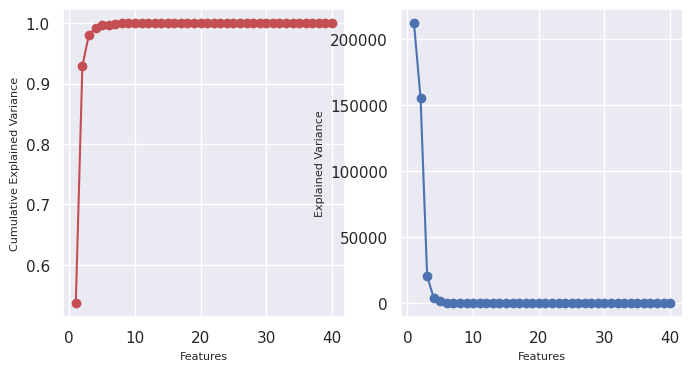

In [ ]:
prop_var = pca.explained_variance_ratio_

fig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].plot(range(1,len(prop_var)+1),np.cumsum(prop_var), 'ro-')
axs[0].set_xlabel('Features', fontsize=8)
axs[0].set_ylabel('Cumulative Explained Variance', fontsize=8)
axs[1].plot(range(1,len(prop_var)+1),pca.explained_variance_,'bo-')
axs[1].set_ylabel('Explained Variance', fontsize=8)
axs[1].set_xlabel('Features', fontsize=8)
plt.show()

In [ ]:
#@title PCA choice
max_component = 26 #@param {type:"slider", min:0, max:45, step:1}
# 12 seems to be a good choice

X_train = X_hat_train.loc[:,:max_component] #keep only the principals components
X_test = X_hat_test.loc[:,:max_component] #keep only the principals components

X_train_class  = X_hat_train_class .loc[:,:max_component] #keep only the principals components
X_test_class  = X_hat_test_class .loc[:,:max_component] #keep only the principals components

print('Amount of variance explained by the choice of principal components : {}'.format(round(np.sum(prop_var[:max_component+1]),3)))

weights = pd.DataFrame(np.transpose(pca.components_), index=input_columns)
fig = px.bar(weights.loc[:,:max_component],title="Weight")
fig.show() # double clicked on a component in the legend to isolate


NameError: ignored

# Prediction models



## Classification


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

def class_report(Y_test,Y_pred,name=''):
  '''
  Print classification report
  '''
  print(name)
  print('-'*60)
  print(classification_report(Y_test, Y_pred, target_names=target_names))
  print('-'*60)
  cm = confusion_matrix(Y_test, Y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
  disp.plot()
  print('='*60)

### Random Forest

30d_return
------------------------------------------------------------
                 precision    recall  f1-score   support

    High Profit       0.87      0.87      0.87        15
      High loss       0.85      0.78      0.82        37
  Marginal Loss       0.79      0.82      0.81        73
Marginal Profit       0.74      0.74      0.74        34

       accuracy                           0.80       159
      macro avg       0.81      0.80      0.81       159
   weighted avg       0.80      0.80      0.80       159

------------------------------------------------------------
90d_return
------------------------------------------------------------
                 precision    recall  f1-score   support

    High Profit       1.00      0.75      0.86        12
      High loss       0.96      0.91      0.93        54
  Marginal Loss       0.79      0.89      0.84        56
Marginal Profit       0.83      0.81      0.82        37

       accuracy                           0.87   

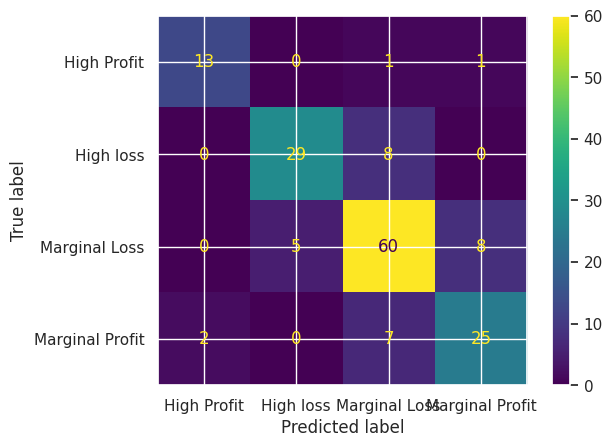

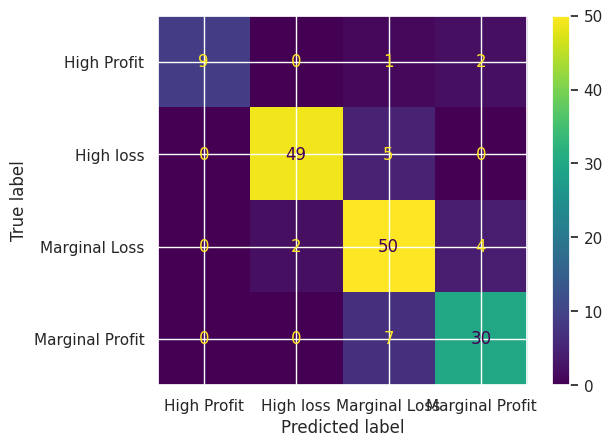

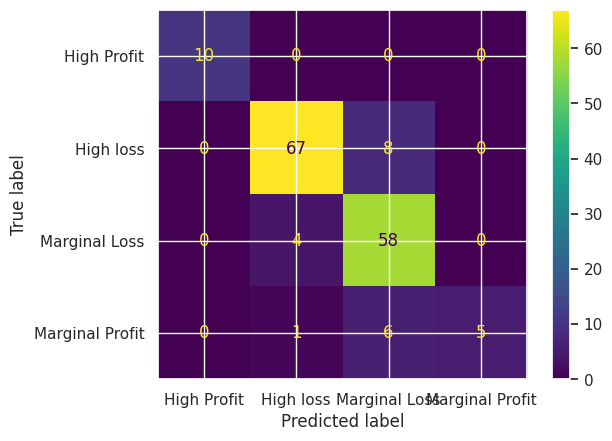

In [ ]:
from sklearn.ensemble import RandomForestClassifier

parameters = {
    'n_estimators' : [i * 100 for i in range(2,6,1)]
}

# Define class weights
class_weights = {0: 0.5,1: 1, 2: 0.5, 3: 1}
for i in range(Y_class.shape[1]):
  # Train a random forest classifier on the training set
  rf_classifier = RandomForestClassifier(random_state=42, class_weight=class_weights)
  BestRF = GridSearchCV(rf_classifier, parameters)
  BestRF.fit(X_train_class, Y_train_class[:,i])

  # Make predictions on the testing set
  Y_pred = BestRF.predict(X_test_class.to_numpy())

  # Print classification report
  class_report(Y_test_class[:,i], Y_pred,target_return_names[i])


**Metrics and definition**
* **Precision** ->	Precision is defined as the ratio of true positives to the sum of true and false positives.
* **Recall** ->	Recall is defined as the ratio of true positives to the sum of true positives and false negatives.
* **F1 Score**	-> The F1 is the weighted harmonic mean of precision and recall. The closer the value of the F1 score is to 1.0, the better the expected performance of the model is.
* **Support** ->	Support is the number of actual occurrences of the class in the dataset. It doesn’t vary between models, it just diagnoses the performance evaluation process.


### Probabilistic discriminative approach: Logistic Regression

Let us change the methods for the classification task and use a Logistic regression classifier with two classes:
- Hypothesis space: $y_n = y(x_n) = \sigma(w_0 + x_{n1} w_1 + x_{n2} w_2)$;
- Loss measure: Loglikelihood $L(\mathbf{w}) = -\sum_{n=1}^N  [C_n \ln y_n + (1 - C_n) \ln (1 - y_n)]$;
- Optimization method: Gradient Descent;

where the sigmoid function is defined as $\sigma(x) = \frac{1}{1 + e^{-x}}$.
* Pros:
  * Can be simpler and faster to train, since it only needs to estimate the conditional distribution of the labels given the features.
  * May be more effective at capturing the decision boundaries between classes, since it focuses on modeling the conditional distribution of the labels.
  * Can be more interpretable, since it provides a clear probabilistic interpretation of the classification decision.
* Cons:
  * Can be less robust to missing data and noisy data, since it only models the conditional distribution of the labels given the features.
  * May be more prone to overfitting, since it only models the conditional distribution of the labels given the features and may not capture the full distribution of the data.




/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/

30d_return
------------------------------------------------------------
                 precision    recall  f1-score   support

    High Profit       0.48      0.87      0.62        15
      High loss       0.50      0.70      0.58        37
  Marginal Loss       0.72      0.42      0.53        73
Marginal Profit       0.49      0.53      0.51        34

       accuracy                           0.55       159
      macro avg       0.55      0.63      0.56       159
   weighted avg       0.60      0.55      0.55       159

------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/

90d_return
------------------------------------------------------------
                 precision    recall  f1-score   support

    High Profit       0.67      0.17      0.27        12
      High loss       0.59      0.78      0.67        54
  Marginal Loss       0.64      0.45      0.53        56
Marginal Profit       0.48      0.59      0.53        37

       accuracy                           0.57       159
      macro avg       0.59      0.50      0.50       159
   weighted avg       0.59      0.57      0.56       159

------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/usr/local/lib/python3.10/dist-packages/sklearn/

180d_return
------------------------------------------------------------
                 precision    recall  f1-score   support

    High Profit       0.33      0.20      0.25        10
      High loss       0.82      0.77      0.79        75
  Marginal Loss       0.71      0.63      0.67        62
Marginal Profit       0.19      0.42      0.26        12

       accuracy                           0.65       159
      macro avg       0.51      0.50      0.49       159
   weighted avg       0.70      0.65      0.67       159

------------------------------------------------------------


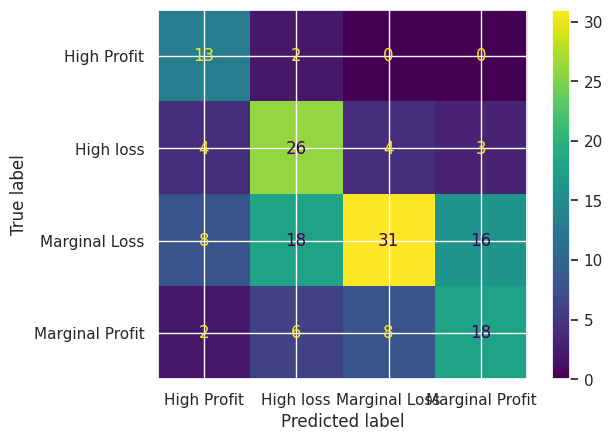

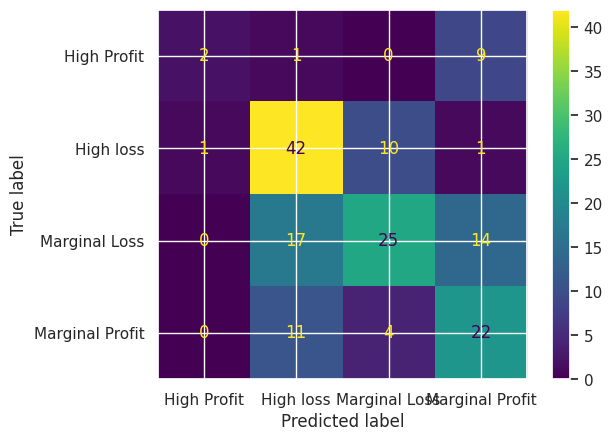

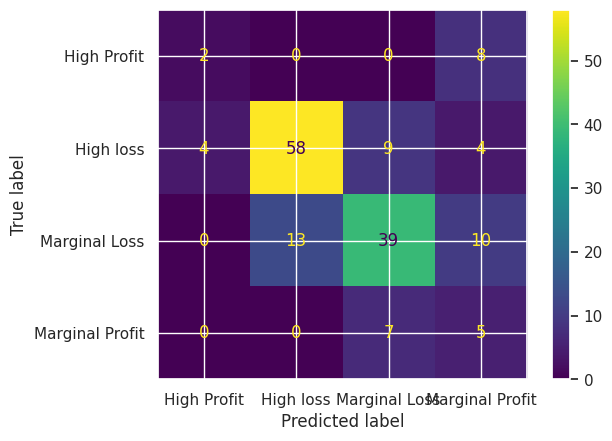

In [ ]:
from sklearn.linear_model import LogisticRegression

parameters = {
    'C' : [i*10 for i in range(2,5)]
}

for i in range(Y_class.shape[1]):
  # Train a Logistic Regression classifier on the training set
  log_classifier = LogisticRegression() # regularization is applied as default
  BestLog = GridSearchCV(log_classifier, parameters)
  BestLog.fit(X_train_class, Y_train_class[:,i])

  # Make predictions on the testing set
  Y_pred = BestLog.predict(X_test_class)

  # Print classification report
  class_report(Y_test_class[:,i], Y_pred,target_return_names[i])

In [ ]:
BestRF.best_params_

{'n_estimators': 500}

### Probabilistic generative approach: Naive Bayes


Generative models have the purpose of modeling the joint pdf of the couple input/output $p(C_k,\mathbf{x})$, which allows us to generate also **new data** from what we learned.

This is different from the probabilistic discriminative models, in which we are only interested in computing the probabilities that a given input is coming from a specific class $p(C_k | \mathbf{x})$, which is not sufficient to produce new samples.

Conversely, we will see how it is possible to generate new samples if we are provided with an approximation of the joint input/output distribution $p(C_k,\mathbf{x})$.

In this case, the Naive Bayes method considers the **naive assumption** that each input is conditionally (w.r.t. the class) independent from each other.
If we consider the Bayes formula we have:
\begin{align*}
	& p(C_k | \mathbf{x}) = \frac{p(C_k) \ p(\mathbf{x} | C_k)}{p(\mathbf{x})} \\
	& \propto p(x_1, \ldots, x_M, C_k)\\
	& = p(x_1 | x_2, \ldots, x_M, C_k) p(x_2, \ldots, x_M, C_k) \\
	& = p(x_1 | x_2, \ldots, x_M, C_k) p(x_2 | x_3, \ldots, x_M, C_k) p(x_3, \ldots, x_n, C_k) \\
	& = p(x_1 \vert x_2, \ldots, x_M, C_k) \ldots p(x_M | C_k) p(C_k) \\
	& = p(x_1 \vert C_k) \ldots p(x_M | C_k) p(C_k) \\
	& = p(C_k) \prod_{j=1}^M p(x_j | C_k).
\end{align*}

The decision function, which maximises the Maximum A Posteriori probability, is the following:
\begin{equation*}
	y(\mathbf{x}) = \arg \max_k p(C_k) \prod_{j=1}^M p(x_j | C_k),
\end{equation*}
where as usual we do not consider the normalization factor $p(\mathbf{x})$.

In a specific case we have to define a prior distribution for the classes $p(C_k) \ \forall k$ and a distribution to compute the likelihood of the considered samples $p(x_j | C_k) \ \forall J, \ \forall k$.

In the case of continuous variable one of the usual assumption is to use Gaussian distributions for each variable $p(x_j | C_k) = \mathcal{N}(x_j;\mu_{jk},\sigma^2_{jk})$ and either a uniform prior $p(C_k) = \frac{1}{K}$ or a multinomial prior based on the samples proportions $p(C_k) = \frac{\sum_{i=1}^N I \{\mathbf{x}_n \in C_k \}}{N}$, where $I\{\cdot\}$ is the indicator function.

The complete model of Naive Bayes is:
- Hypothesis space: $y_n = y(x_n) = \arg \max_k p(C_k) \prod_{j=1}^M p(x_j | C_k)$;
- Loss measure: Log likelihood;
- Optimization method: MLE.

* Pros:
 * Can handle missing data and noisy data well, since it models the joint distribution of features and labels.
  * Can be more robust to overfitting, since it estimates the full distribution of the data rather than just the conditional distribution of the labels.
  * Can be useful for generating synthetic data that follows the same distribution as the training data.
* Cons:
  * Can be computationally more expensive, since it involves estimating the joint distribution.
  * Can suffer from the curse of dimensionality when dealing with high-dimensional feature spaces.
  * May not be as good at capturing the subtle decision boundaries between classes, since it models the distribution of the data as a whole rather than just the boundaries between classes.


30d_return
------------------------------------------------------------
                 precision    recall  f1-score   support

    High Profit       0.86      0.80      0.83        15
      High loss       0.83      0.78      0.81        37
  Marginal Loss       0.68      0.74      0.71        73
Marginal Profit       0.58      0.53      0.55        34

       accuracy                           0.71       159
      macro avg       0.74      0.71      0.72       159
   weighted avg       0.71      0.71      0.71       159

------------------------------------------------------------
90d_return
------------------------------------------------------------
                 precision    recall  f1-score   support

    High Profit       0.86      0.50      0.63        12
      High loss       0.78      0.74      0.76        54
  Marginal Loss       0.59      0.75      0.66        56
Marginal Profit       0.60      0.49      0.54        37

       accuracy                           0.67   

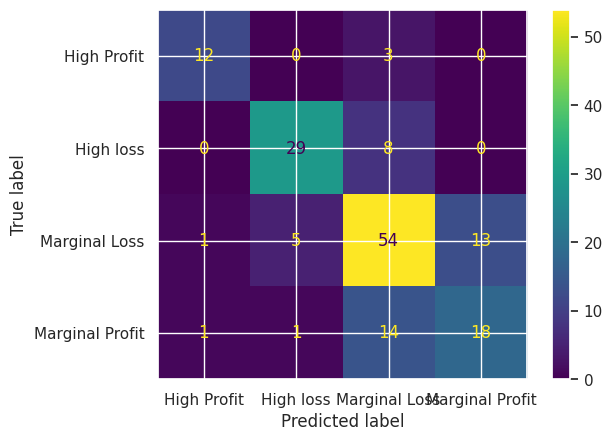

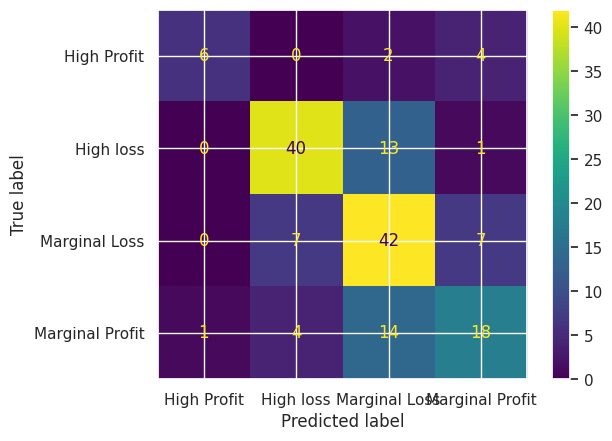

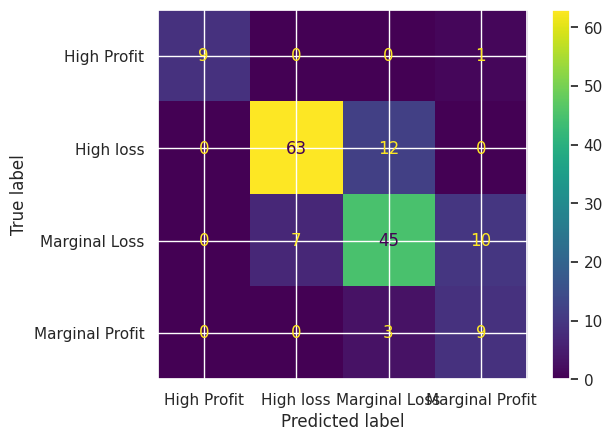

In [ ]:
from sklearn.naive_bayes import GaussianNB

for i in range(Y_class.shape[1]):

  # Train a Naive Bayes classifier on the training set
  gnb_classifier = GaussianNB()
  gnb_classifier.fit(X_train_class, Y_train_class[:,i])

  # Make predictions on the testing set
  Y_pred = gnb_classifier.predict(X_test_class)

  # Print classification report
  class_report(Y_test_class[:,i], Y_pred,target_return_names[i])

### Quadratic Discriminant Analysis

30d_return
------------------------------------------------------------
                 precision    recall  f1-score   support

    High Profit       0.78      0.93      0.85        15
      High loss       0.77      0.81      0.79        37
  Marginal Loss       0.72      0.74      0.73        73
Marginal Profit       0.52      0.41      0.46        34

       accuracy                           0.70       159
      macro avg       0.70      0.72      0.71       159
   weighted avg       0.69      0.70      0.70       159

------------------------------------------------------------
90d_return
------------------------------------------------------------
                 precision    recall  f1-score   support

    High Profit       1.00      0.92      0.96        12
      High loss       0.84      0.91      0.88        54
  Marginal Loss       0.73      0.77      0.75        56
Marginal Profit       0.81      0.68      0.74        37

       accuracy                           0.81   

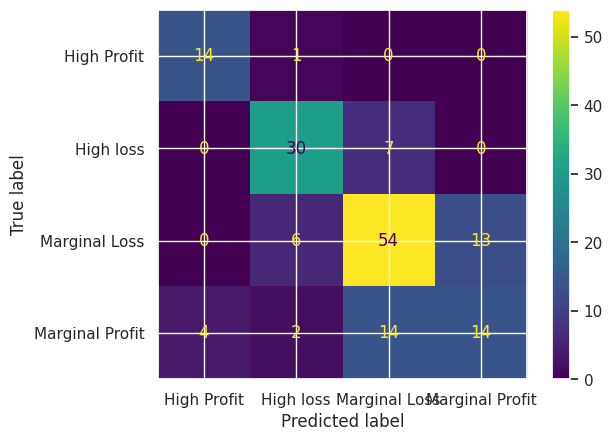

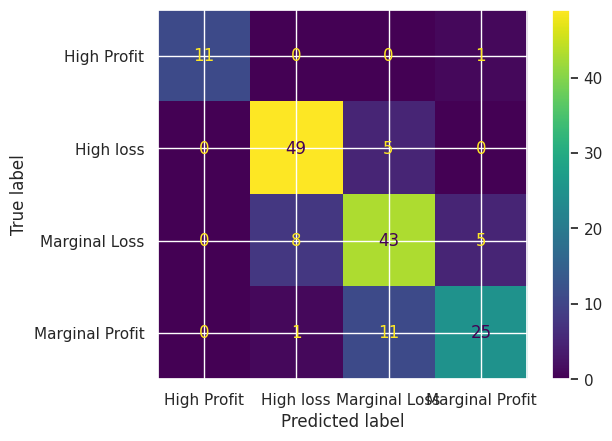

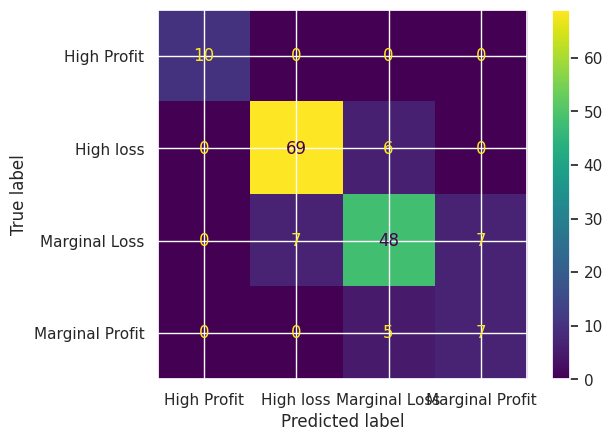

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

for i in range(Y_class.shape[1]):

  # Train a Naive Bayes classifier on the training set
  QDA_classifier = QuadraticDiscriminantAnalysis()
  QDA_classifier.fit(X_train_class, Y_train_class[:,i])

  # Make predictions on the testing set
  Y_pred = QDA_classifier.predict(X_test_class)

  # Print classification report
  class_report(Y_test_class[:,i], Y_pred,target_return_names[i])

###SVM

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: Convergen

30d_return
------------------------------------------------------------
                 precision    recall  f1-score   support

    High Profit       0.40      0.27      0.32        15
      High loss       0.64      0.19      0.29        37
  Marginal Loss       0.42      0.47      0.44        73
Marginal Profit       0.36      0.62      0.46        34

       accuracy                           0.42       159
      macro avg       0.46      0.38      0.38       159
   weighted avg       0.46      0.42      0.40       159

------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: Convergen

90d_return
------------------------------------------------------------
                 precision    recall  f1-score   support

    High Profit       0.50      0.50      0.50        12
      High loss       0.46      0.48      0.47        54
  Marginal Loss       0.59      0.57      0.58        56
Marginal Profit       0.14      0.14      0.14        37

       accuracy                           0.43       159
      macro avg       0.42      0.42      0.42       159
   weighted avg       0.44      0.43      0.43       159

------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: Convergen

180d_return
------------------------------------------------------------
                 precision    recall  f1-score   support

    High Profit       0.14      0.40      0.21        10
      High loss       0.76      0.72      0.74        75
  Marginal Loss       0.49      0.35      0.41        62
Marginal Profit       0.13      0.17      0.15        12

       accuracy                           0.52       159
      macro avg       0.38      0.41      0.38       159
   weighted avg       0.57      0.52      0.53       159

------------------------------------------------------------


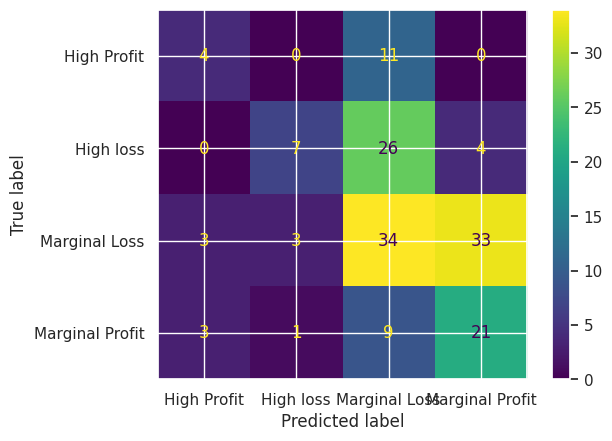

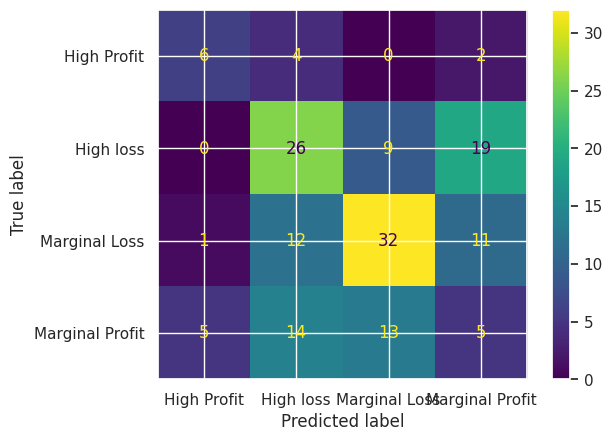

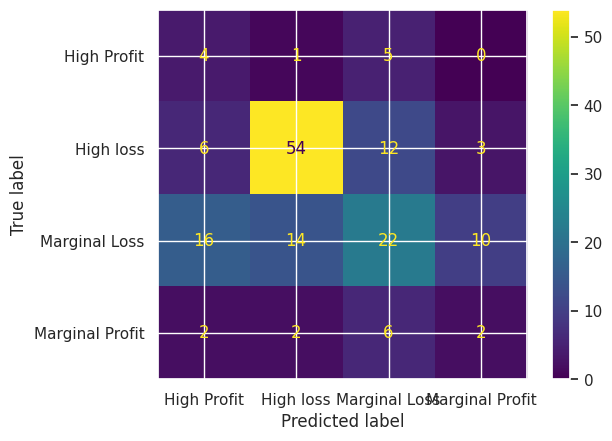

In [ ]:
from sklearn.svm import LinearSVC
parameters = {'C':[20,50]}

for i in range(Y_class.shape[1]):

  # Train a Naive Bayes classifier on the training set
  svm_classifier = LinearSVC(max_iter=1000)
  BestSVM = GridSearchCV(svm_classifier, parameters)
  BestSVM.fit(X_train_class, Y_train_class[:,i])

  # Make predictions on the testing set
  Y_pred = BestSVM.predict(X_test_class)

  # Print classification report
  class_report(Y_test_class[:,i], Y_pred,target_return_names[i])

In [ ]:
parameters

{'C': [20, 50]}

In [ ]:
BestSVM.best_params_

{'C': 20}

### Perceptron

In [ ]:
from sklearn.linear_model import Perceptron

for i in range(Y_class.shape[1]):

  # Train a Naive Bayes classifier on the training set
  per_classifier = Perceptron()
  per_classifier.fit(X_train_class, Y_train_class[:,i])

  # Make predictions on the testing set
  Y_pred = per_classifier.predict(X_test_class)

  # Print classification report
  class_report(Y_test_class[:,i], Y_pred,target_return_names[i])

30d_return
------------------------------------------------------------
                 precision    recall  f1-score   support

    High Profit       0.00      0.00      0.00        15
      High loss       0.00      0.00      0.00        37
  Marginal Loss       0.47      0.68      0.56        73
Marginal Profit       0.28      0.44      0.34        34

       accuracy                           0.41       159
      macro avg       0.19      0.28      0.23       159
   weighted avg       0.28      0.41      0.33       159

------------------------------------------------------------
[[ 0  0 12  3]
 [ 0  0 25 12]
 [ 0  0 50 23]
 [ 0  0 19 15]]
90d_return
------------------------------------------------------------
                 precision    recall  f1-score   support

    High Profit       0.00      0.00      0.00        12
      High loss       0.37      0.96      0.53        54
  Marginal Loss       0.00      0.00      0.00        56
Marginal Profit       0.80      0.11      0.19

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` p

## Regression

all the point should be on red line (prediction = test)

misclassified loss : not good <=> predict loss but actually is profit
--> infinite loss

misclassified profit : less not good <=> predict profit but actually is loss
--> actif price loss

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

def regression_report(Y_test,Y_pred,name=''):
  print(name)
  print('-'*60)
  print('R²: ',r2_score(Y_test, Y_pred))
  print('Mean absolute error : ',mean_absolute_error(Y_test, Y_pred))
  print('% of missclassified sign : ', round(np.count_nonzero(Y_test * Y_pred < 0) / Y_pred.shape[0] * 100)) # top left and bottom right)
  print('% of missclassified profit : ', round(np.count_nonzero(np.logical_and(Y_test < 0, Y_pred > 0)) / Y_pred.shape[0] * 100)) # top left
  print('% of missclassified loss : ', round(np.count_nonzero(np.logical_and(Y_test > 0, Y_pred < 0)) / Y_pred.shape[0] * 100)) # bottom right
  temp = np.sign(Y_test) * np.sign(Y_pred) * np.abs(Y_pred)
  print('Return : ', round(np.sum(temp),2) , '%')
  print('Return cov : ', np.cov(temp))
  dataMin,dataMax = min([Y_test.min(), Y_pred.min()]),max([Y_test.max(), Y_pred.max()])
  fig, axs = plt.subplots(1,2,figsize=(10, 5))
  axs[0].plot([dataMin,dataMax],[dataMin,dataMax],'r-')
  axs[0].scatter(Y_test, Y_pred)
  axs[0].set_title('Accuracy of prediction')
  axs[0].set_xlabel('Real values')
  axs[0].set_ylabel('Predicted values')
  axs[1].scatter(Y_pred, Y_test-Y_pred)
  axs[1].set_title('Residual analysis')
  axs[1].set_xlabel('Predicted values')
  axs[1].set_ylabel('Residual values')

  plt.show()
  print('='*60)

### Ridge

30d_return
------------------------------------------------------------
R²:  0.09955191040965727
Mean absolute error :  0.09776325764081549
% of missclassified sign :  35
% of missclassified profit :  7
% of missclassified loss :  28
Return :  2.75 %
Return cov :  0.0023070461382008957


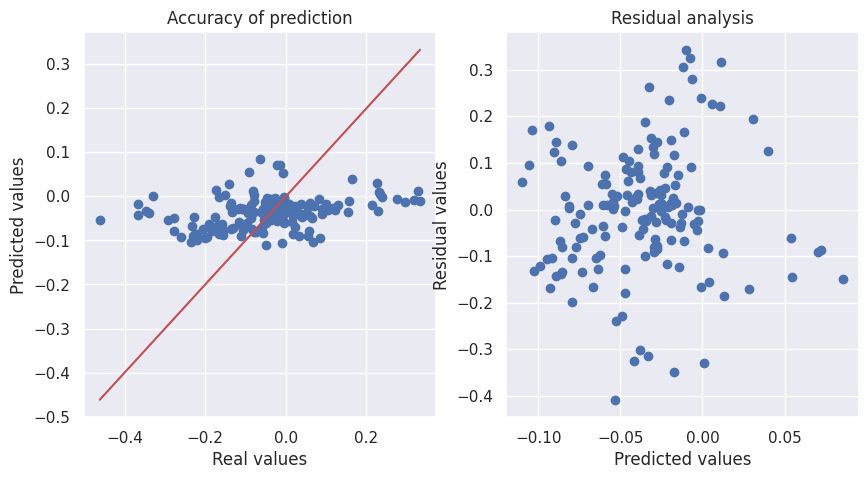

90d_return
------------------------------------------------------------
R²:  0.14056566219937983
Mean absolute error :  0.15833152998093716
% of missclassified sign :  32
% of missclassified profit :  5
% of missclassified loss :  27
Return :  10.12 %
Return cov :  0.01938582441036926


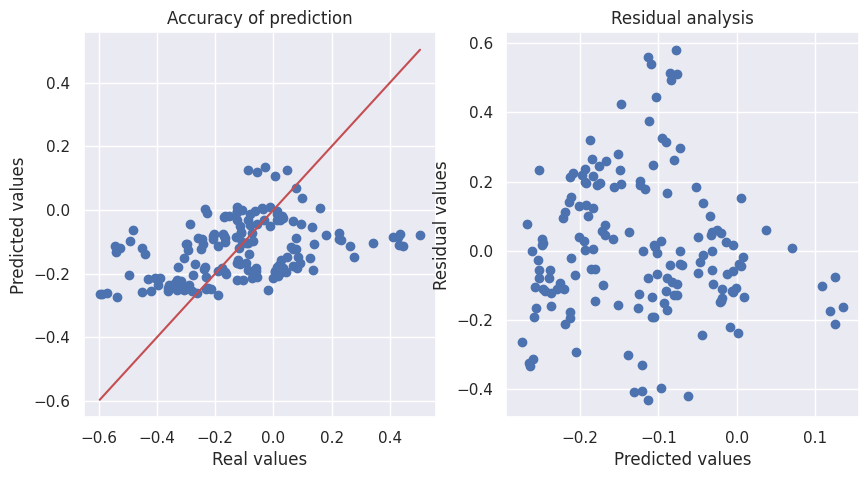

180d_return
------------------------------------------------------------
R²:  0.36267911649540396
Mean absolute error :  0.16194974438178802
% of missclassified sign :  13
% of missclassified profit :  4
% of missclassified loss :  9
Return :  33.93 %
Return cov :  0.033733012681837024


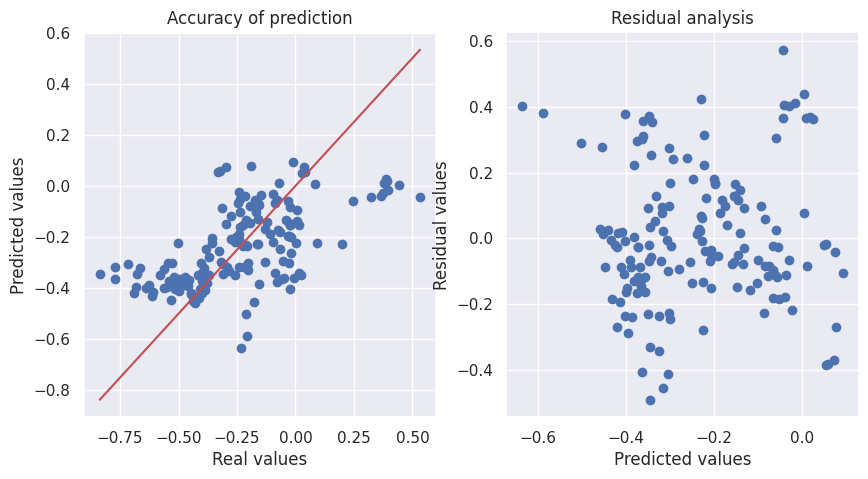

In [ ]:
from sklearn.linear_model import RidgeCV

for i in range(len(target_return_names)):

  ridge_regressor = RidgeCV(alphas=np.linspace(0.1,100,100),cv=10)
  ridge_regressor.fit(X_train, Y_train.loc[:,target_return_names[i]])

  # Make predictions on the testing set
  Y_pred = ridge_regressor.predict(X_test)

  # Print regression report
  regression_report(Y_test.loc[:,target_return_names[i]], Y_pred,target_return_names[i])


In [ ]:
ridge_regressor.coef_

array([-8.60509569e-05, -7.34883666e-05,  8.94868769e-05,  4.10163621e-04,
        2.91694886e-03,  2.08320759e-03])

### Lasso

30d_return
------------------------------------------------------------
R²:  0.09943611985061662
Mean absolute error :  0.09776303369304672
% of missclassified sign :  35
% of missclassified profit :  7
% of missclassified loss :  28
Return :  2.75 %
Return cov :  0.002300243411562696


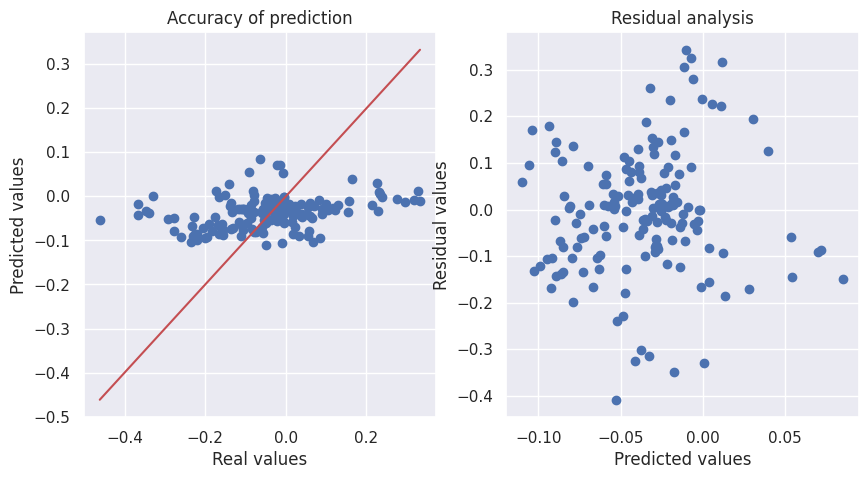

90d_return
------------------------------------------------------------
R²:  0.14122969837630261
Mean absolute error :  0.15811665430742192
% of missclassified sign :  32
% of missclassified profit :  5
% of missclassified loss :  27
Return :  10.09 %
Return cov :  0.019293842832039165


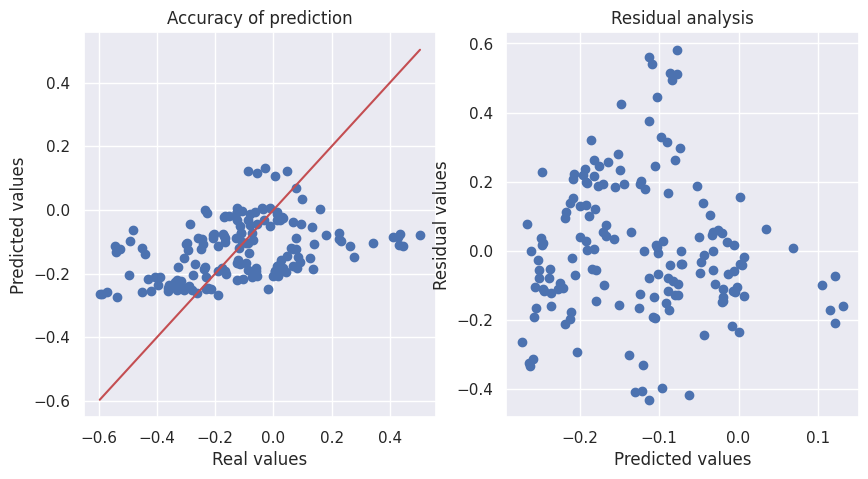

180d_return
------------------------------------------------------------
R²:  0.3635177127471595
Mean absolute error :  0.16185012500865878
% of missclassified sign :  13
% of missclassified profit :  4
% of missclassified loss :  9
Return :  33.85 %
Return cov :  0.03346454325485169


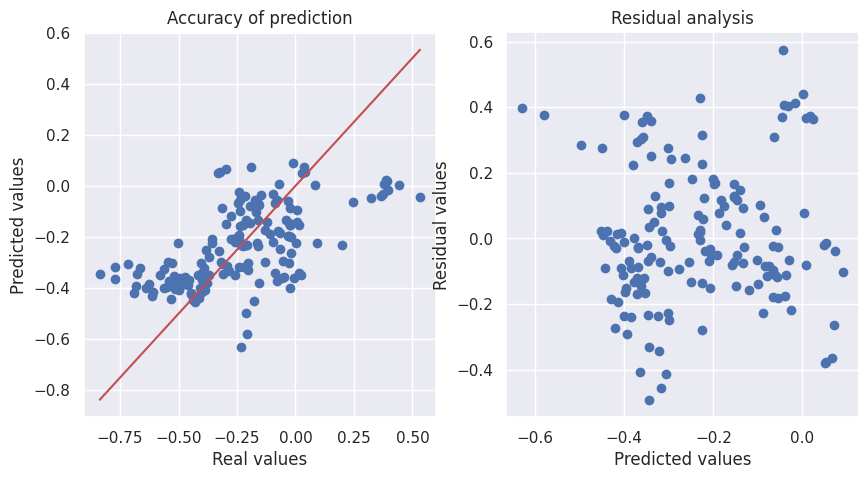

In [ ]:
from sklearn.linear_model import LassoCV

for i in range(len(target_return_names)):

  lasso_regressor = LassoCV(cv=10)
  lasso_regressor.fit(X_train.to_numpy(), Y_train.loc[:,target_return_names[i]])

  # Make predictions on the testing set
  Y_pred = lasso_regressor.predict(X_test)

  # Print regression report
  regression_report(Y_test.loc[:,target_return_names[i]], Y_pred,target_return_names[i])

###SVM regression

30d_return
------------------------------------------------------------
R²:  0.7302220105469543
Mean absolute error :  0.055509173326304256
% of missclassified sign :  21
% of missclassified profit :  9
% of missclassified loss :  12
Return :  12.85 %
Return cov :  0.008027001982296517


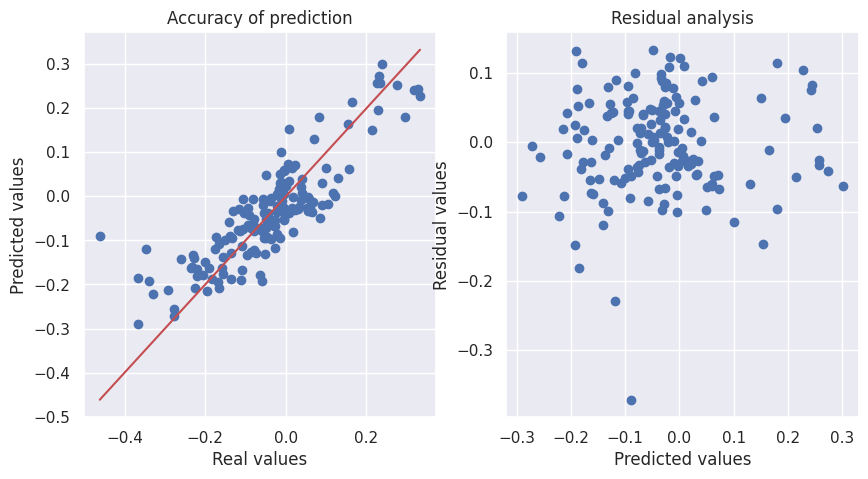

90d_return
------------------------------------------------------------
R²:  0.8464273825576479
Mean absolute error :  0.06798666267672704
% of missclassified sign :  9
% of missclassified profit :  4
% of missclassified loss :  5
Return :  26.83 %
Return cov :  0.017886752781129136


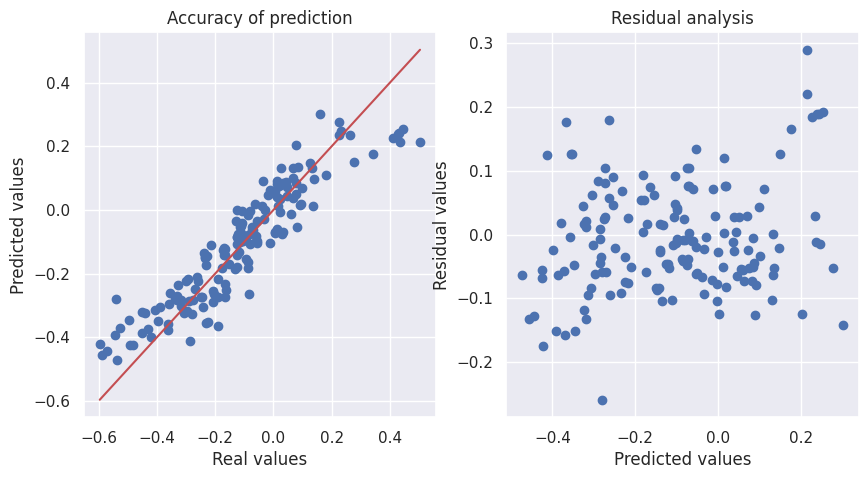

180d_return
------------------------------------------------------------
R²:  0.932387513593607
Mean absolute error :  0.05233723308540548
% of missclassified sign :  6
% of missclassified profit :  2
% of missclassified loss :  4
Return :  43.35 %
Return cov :  0.036216983561409566


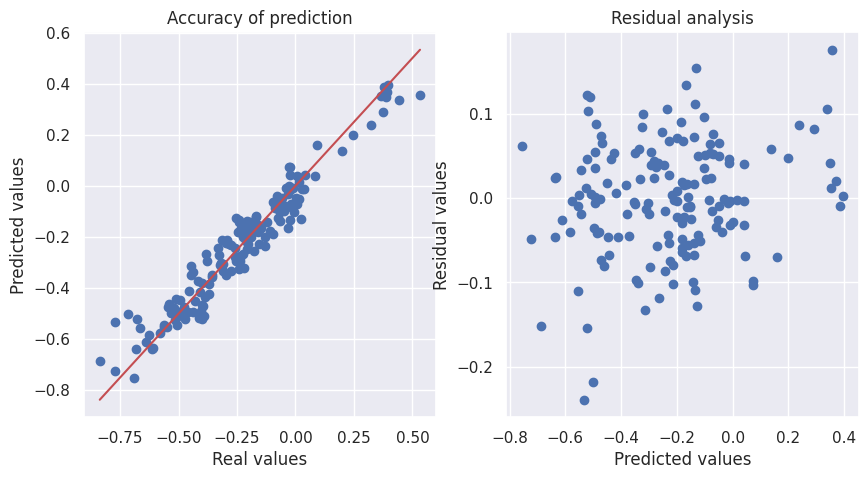

In [ ]:
from sklearn.svm import SVR
parameters = {'C':[1,5,10]}

for i in range(len(target_return_names)):

  # Train a Naive Bayes classifier on the training set
  SVM_regressor = SVR(kernel='rbf')
  BestSVR = GridSearchCV(SVM_regressor, parameters)
  BestSVR.fit(X_train, Y_train.loc[:,target_return_names[i]])

  # Make predictions on the testing set
  Y_pred = BestSVR.predict(X_test)


  # Print regression report
  regression_report(Y_test.loc[:,target_return_names[i]], Y_pred,target_return_names[i])

In [ ]:
BestSVR.best_params_

{'C': 10}

### Gradiant Boosting

30d_return
------------------------------------------------------------
R²:  0.6809440798778318
Mean absolute error :  0.05043342927290831
% of missclassified sign :  16
% of missclassified profit :  11
% of missclassified loss :  5
Return :  12.84 %
Return cov :  0.007532629619938059


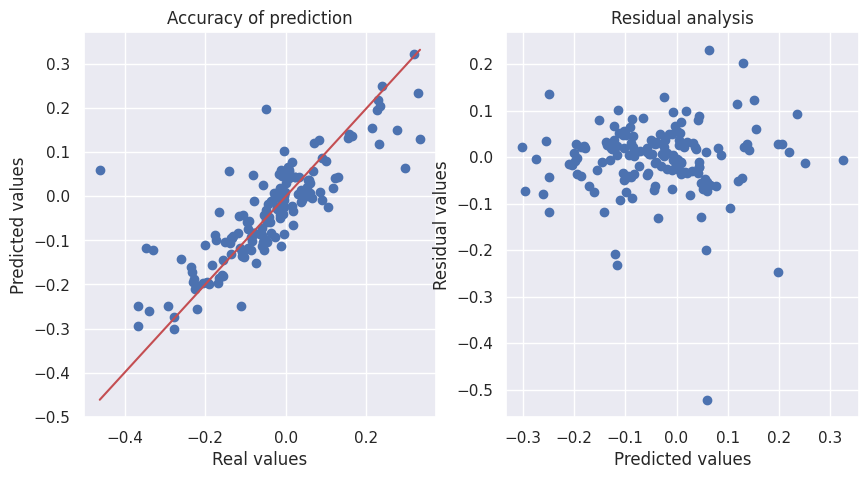

90d_return
------------------------------------------------------------
R²:  0.8257189432674188
Mean absolute error :  0.06118010123248316
% of missclassified sign :  9
% of missclassified profit :  4
% of missclassified loss :  5
Return :  25.45 %
Return cov :  0.018439582626707637


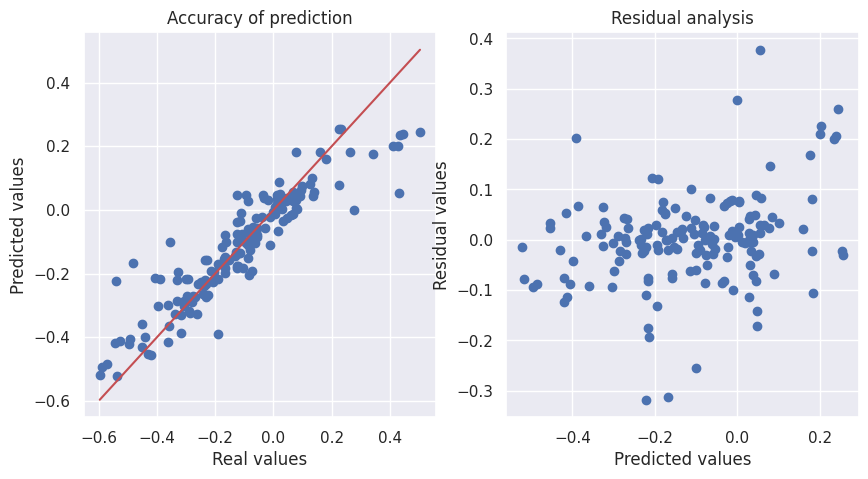

180d_return
------------------------------------------------------------
R²:  0.9055636688856856
Mean absolute error :  0.058476143692788675
% of missclassified sign :  7
% of missclassified profit :  3
% of missclassified loss :  4
Return :  41.68 %
Return cov :  0.03623575556475826


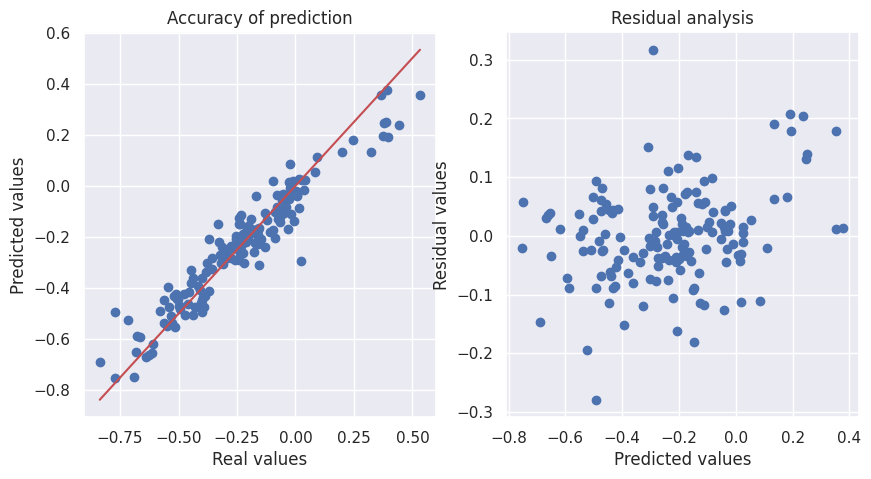

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
parameters = { 'n_estimators':[1000],'learning_rate': [0.1]}

for i in range(len(target_return_names)):

  # Train a Naive Bayes classifier on the training set
  GBoost_regressor = GradientBoostingRegressor(loss='huber')
  BestGBoost = GridSearchCV(GBoost_regressor, parameters)
  BestGBoost.fit(X_train, Y_train.loc[:,target_return_names[i]])

  # Make predictions on the testing set
  Y_pred = BestGBoost.predict(X_test)


  # Print regression report
  regression_report(Y_test.loc[:,target_return_names[i]], Y_pred,target_return_names[i])

In [ ]:
BestGBoost.best_params_

{'learning_rate': 0.1, 'n_estimators': 1000}

### XGBoost

30d_return
------------------------------------------------------------
R²:  0.7756140571807377
Mean absolute error :  0.042846875618804785
% of missclassified sign :  15
% of missclassified profit :  10
% of missclassified loss :  5
Return :  13.97 %
Return cov :  0.008702989328826793


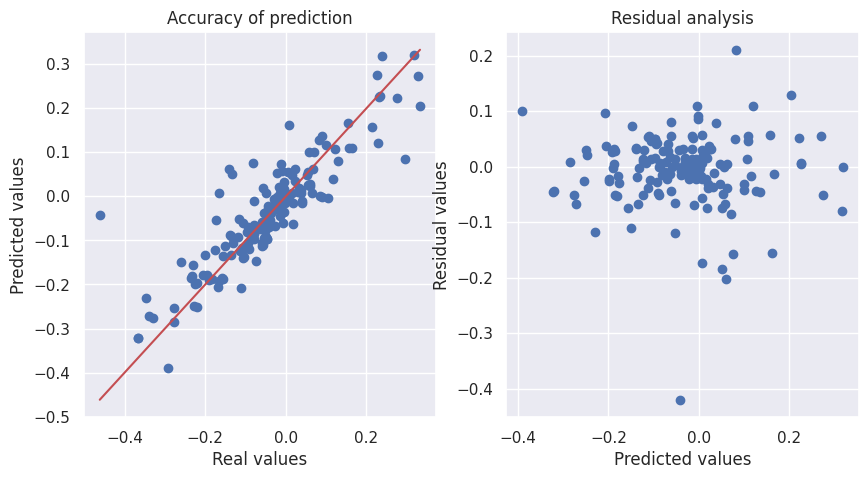

90d_return
------------------------------------------------------------
R²:  0.8257120208343746
Mean absolute error :  0.05382192272634852
% of missclassified sign :  8
% of missclassified profit :  3
% of missclassified loss :  5
Return :  26.46 %
Return cov :  0.021535183326143646


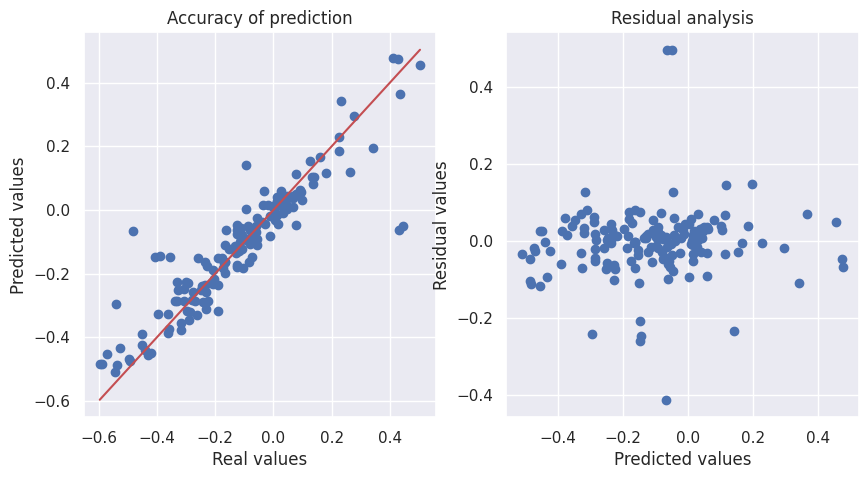

180d_return
------------------------------------------------------------
R²:  0.92457949840802
Mean absolute error :  0.05107812171180205
% of missclassified sign :  4
% of missclassified profit :  1
% of missclassified loss :  3
Return :  42.73 %
Return cov :  0.0337163819394897


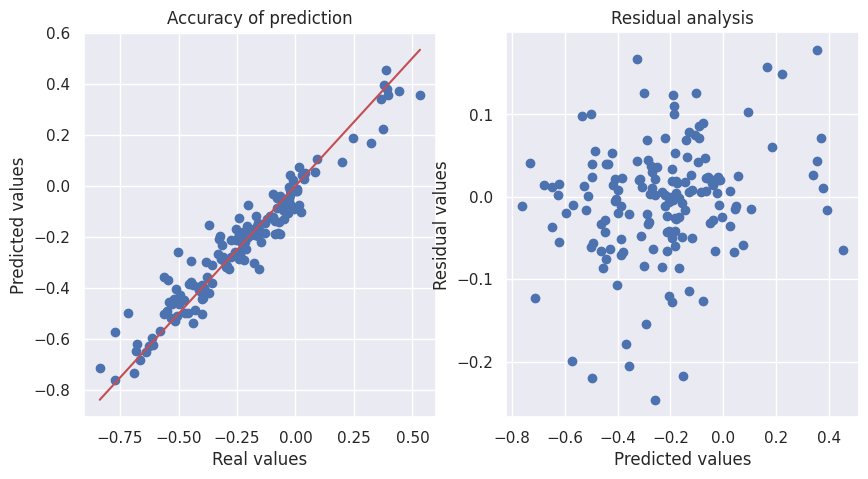

In [ ]:
from xgboost import XGBRegressor
parameters = { 'n_estimators':[500],'max_depth': [7]}

for i in range(len(target_return_names)):

  # Train a Naive Bayes classifier on the training set
  XGBoost = XGBRegressor()
  BestXGBoost = GridSearchCV(XGBoost, parameters)
  BestXGBoost.fit(X_train, Y_train.loc[:,target_return_names[i]])

  # Make predictions on the testing set
  Y_pred = BestXGBoost.predict(X_test)


  # Print regression report
  regression_report(Y_test.loc[:,target_return_names[i]], Y_pred,target_return_names[i])

In [ ]:
BestXGBoost.best_params_

{'max_depth': 7, 'n_estimators': 500}

### (ML)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



30d_return
------------------------------------------------------------
R²:  -40.44143974215363
Mean absolute error :  0.6823615030536827
% of missclassified sign :  38
% of missclassified profit :  28
% of missclassified loss :  9
Return :  43.6 %
Return cov :  0.775701005825139


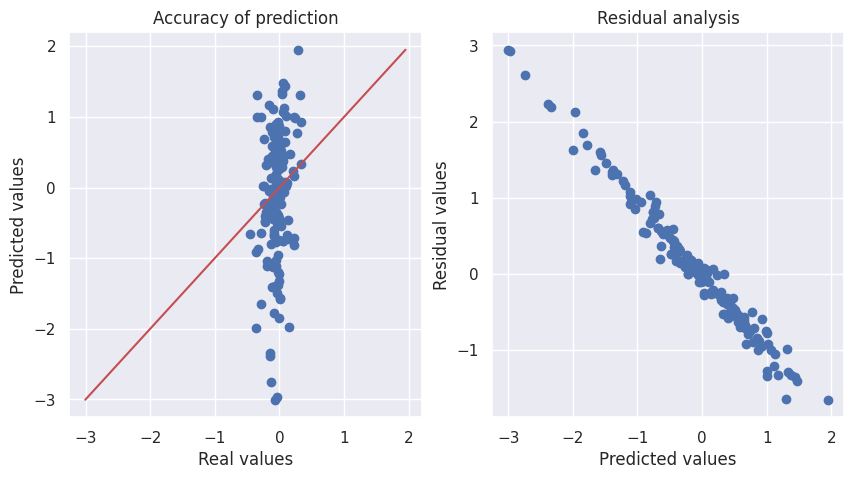

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



90d_return
------------------------------------------------------------
R²:  -59.60871753608549
Mean absolute error :  1.1506206967923056
% of missclassified sign :  47
% of missclassified profit :  28
% of missclassified loss :  19
Return :  -14.46 %
Return cov :  2.8413030758077302


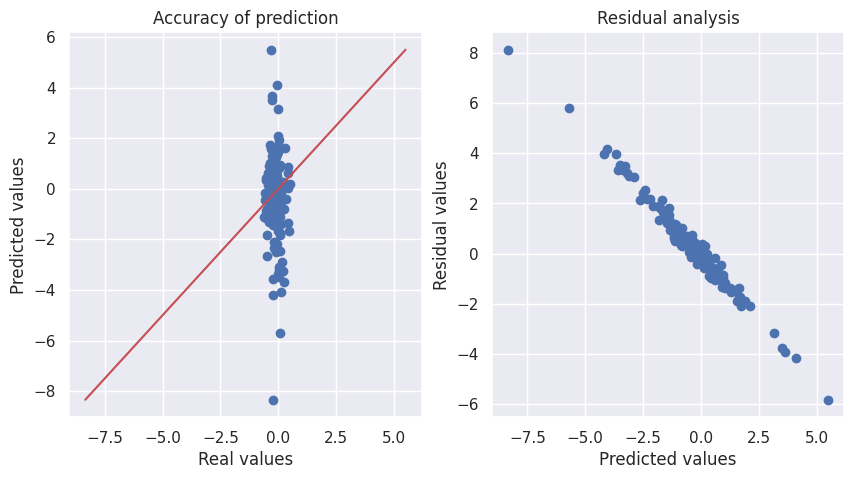

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



180d_return
------------------------------------------------------------
R²:  -19.89915490416773
Mean absolute error :  0.8611469013775562
% of missclassified sign :  33
% of missclassified profit :  28
% of missclassified loss :  5
Return :  60.21 %
Return cov :  1.4261897399720138


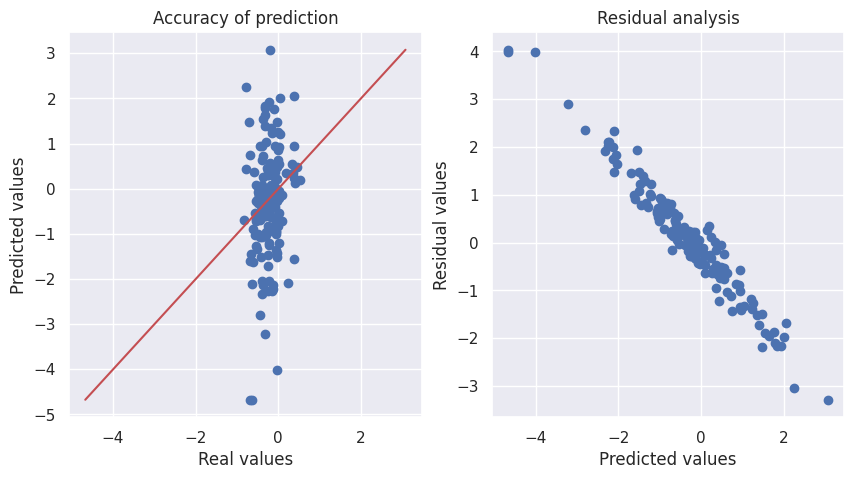

In [ ]:
from sklearn.neural_network import MLPRegressor

for i in range(len(target_return_names)):

  # Train a Naive Bayes classifier on the training set
  ML_regressor = MLPRegressor()
  ML_regressor.fit(X_train, Y_train.loc[:,target_return_names[i]])

  # Make predictions on the testing set
  Y_pred = ML_regressor.predict(X_test)

  # Print regression report
  regression_report(Y_test.loc[:,target_return_names[i]], Y_pred,target_return_names[i])